# Stock Market Prediction - Feature Engineering

This notebook explores and creates technical indicators and features for ML models. 

Dataset: 15 stocks, 11,500+ records (Sep 1 - Oct 15, 2025)

Goals:
1. Load and explore the data
2. Create technical indicators (MA, RSI, MACD, Bollinger Bands)
3. Engineer time-based features
4. Analyze feature correlations
5. Prepare final feature set for modeling

In [1]:
import sys
from pathlib import Path

# Add project root to path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import project modules
from src.data_loader import DataLoader
from src.config import config

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

print("Imports complete")
print(f"Config loaded: {config.data_mode} mode")
print(f"Historical days: {config.HISTORICAL_DAYS}")

Imports complete
Config loaded: LOCAL mode
Historical days: 365


## Load Data

In [2]:
loader = DataLoader(use_local=True)
df = loader.load_all_data()

DataLoader initialized in LOCAL mode.

Loading all available stock data...

Loading data from /home/pius/dev-projects/stock-market-prediction/data/raw/all_stocks_historical.parquet...
Loaded 11,500 records from local parquet file.
✅ Loaded 11,500 records for 15 stocks


In [4]:
print(f"Shape: {df.shape}")

Shape: (11500, 13)


In [5]:
print(f"Columns: {df.columns.tolist()}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Columns: ['symbol', 'open_price', 'high', 'low', 'close_price', 'volume', 'market_cap', 'timestamp', 'date_only', 'timestamp_et', 'hour', 'day_of_week', 'is_trading_hours']
Date range: 2025-09-01 07:27:23.423846+00:00 to 2025-10-15 07:12:03.959273+00:00


In [6]:
print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")

Memory usage: 1.91 MB


## Data Inspection

In [7]:
df.head()

,symbol,open_price,high,low,close_price,volume,market_cap,timestamp,date_only,timestamp_et,hour,day_of_week,is_trading_hours
0,2222.SR,23.81,23.82,23.73,23.75,517621,5.744056e+12,2025-09-01 07:27:29.329835+00:00,2025-09-01,2025-09-01 03:27:29.329835-04:00,3,0,False
1,2222.SR,23.70,23.71,23.69,23.69,35782,5.729545e+12,2025-09-01 08:17:47.795969+00:00,2025-09-01,2025-09-01 04:17:47.795969-04:00,4,0,False
2,2222.SR,23.63,23.63,23.63,23.63,0,5.715033e+12,2025-09-01 09:15:07.264998+00:00,2025-09-01,2025-09-01 05:15:07.264998-04:00,5,0,False
3,2222.SR,23.63,23.64,23.60,23.61,2372396,5.710197e+12,2025-09-01 10:14:05.476706+00:00,2025-09-01,2025-09-01 06:14:05.476706-04:00,6,0,False
4,2222.SR,23.61,23.61,23.57,23.59,1521688,5.705360e+12,2025-09-01 11:10:40.868525+00:00,2025-09-01,2025-09-01 07:10:40.868525-04:00,7,0,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype                           
---  ------            --------------  -----                           
 0   symbol            11500 non-null  object                          
 1   open_price        11500 non-null  float64                         
 2   high              11500 non-null  float64                         
 3   low               11500 non-null  float64                         
 4   close_price       11500 non-null  float64                         
 5   volume            11500 non-null  int64                           
 6   market_cap        11499 non-null  float64                         
 7   timestamp         11500 non-null  datetime64[ns, UTC]             
 8   date_only         11500 non-null  object                          
 9   timestamp_et      11500 non-null  datetime64[ns, America/New_York]
 10  hour              1150

## EDA

### Records per Symbol

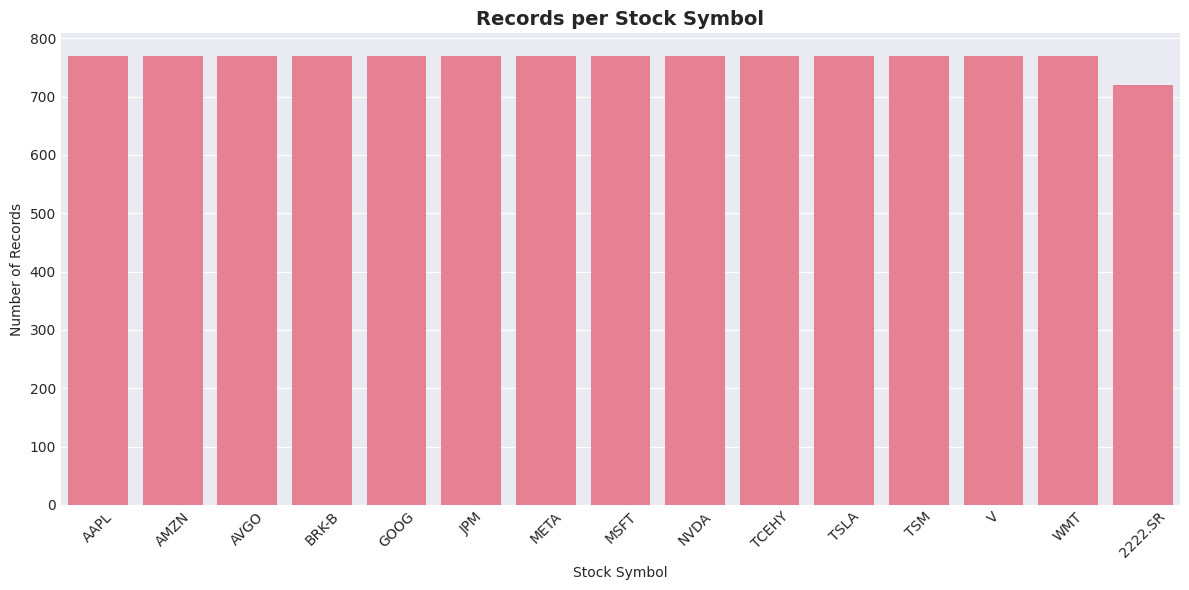

In [9]:
records_per_symbol = df.groupby("symbol").size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=records_per_symbol.index, y=records_per_symbol.values)
plt.title("Records per Stock Symbol", fontsize=14, fontweight="bold")
plt.xlabel("Stock Symbol")
plt.ylabel("Number of Records")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
print("Records per Symbol:")
print(records_per_symbol)

Records per Symbol:
symbol
AAPL       770
AMZN       770
AVGO       770
BRK-B      770
GOOG       770
JPM        770
META       770
MSFT       770
NVDA       770
TCEHY      770
TSLA       770
TSM        770
V          770
WMT        770
2222.SR    720
dtype: int64


### Price Trend Analysis

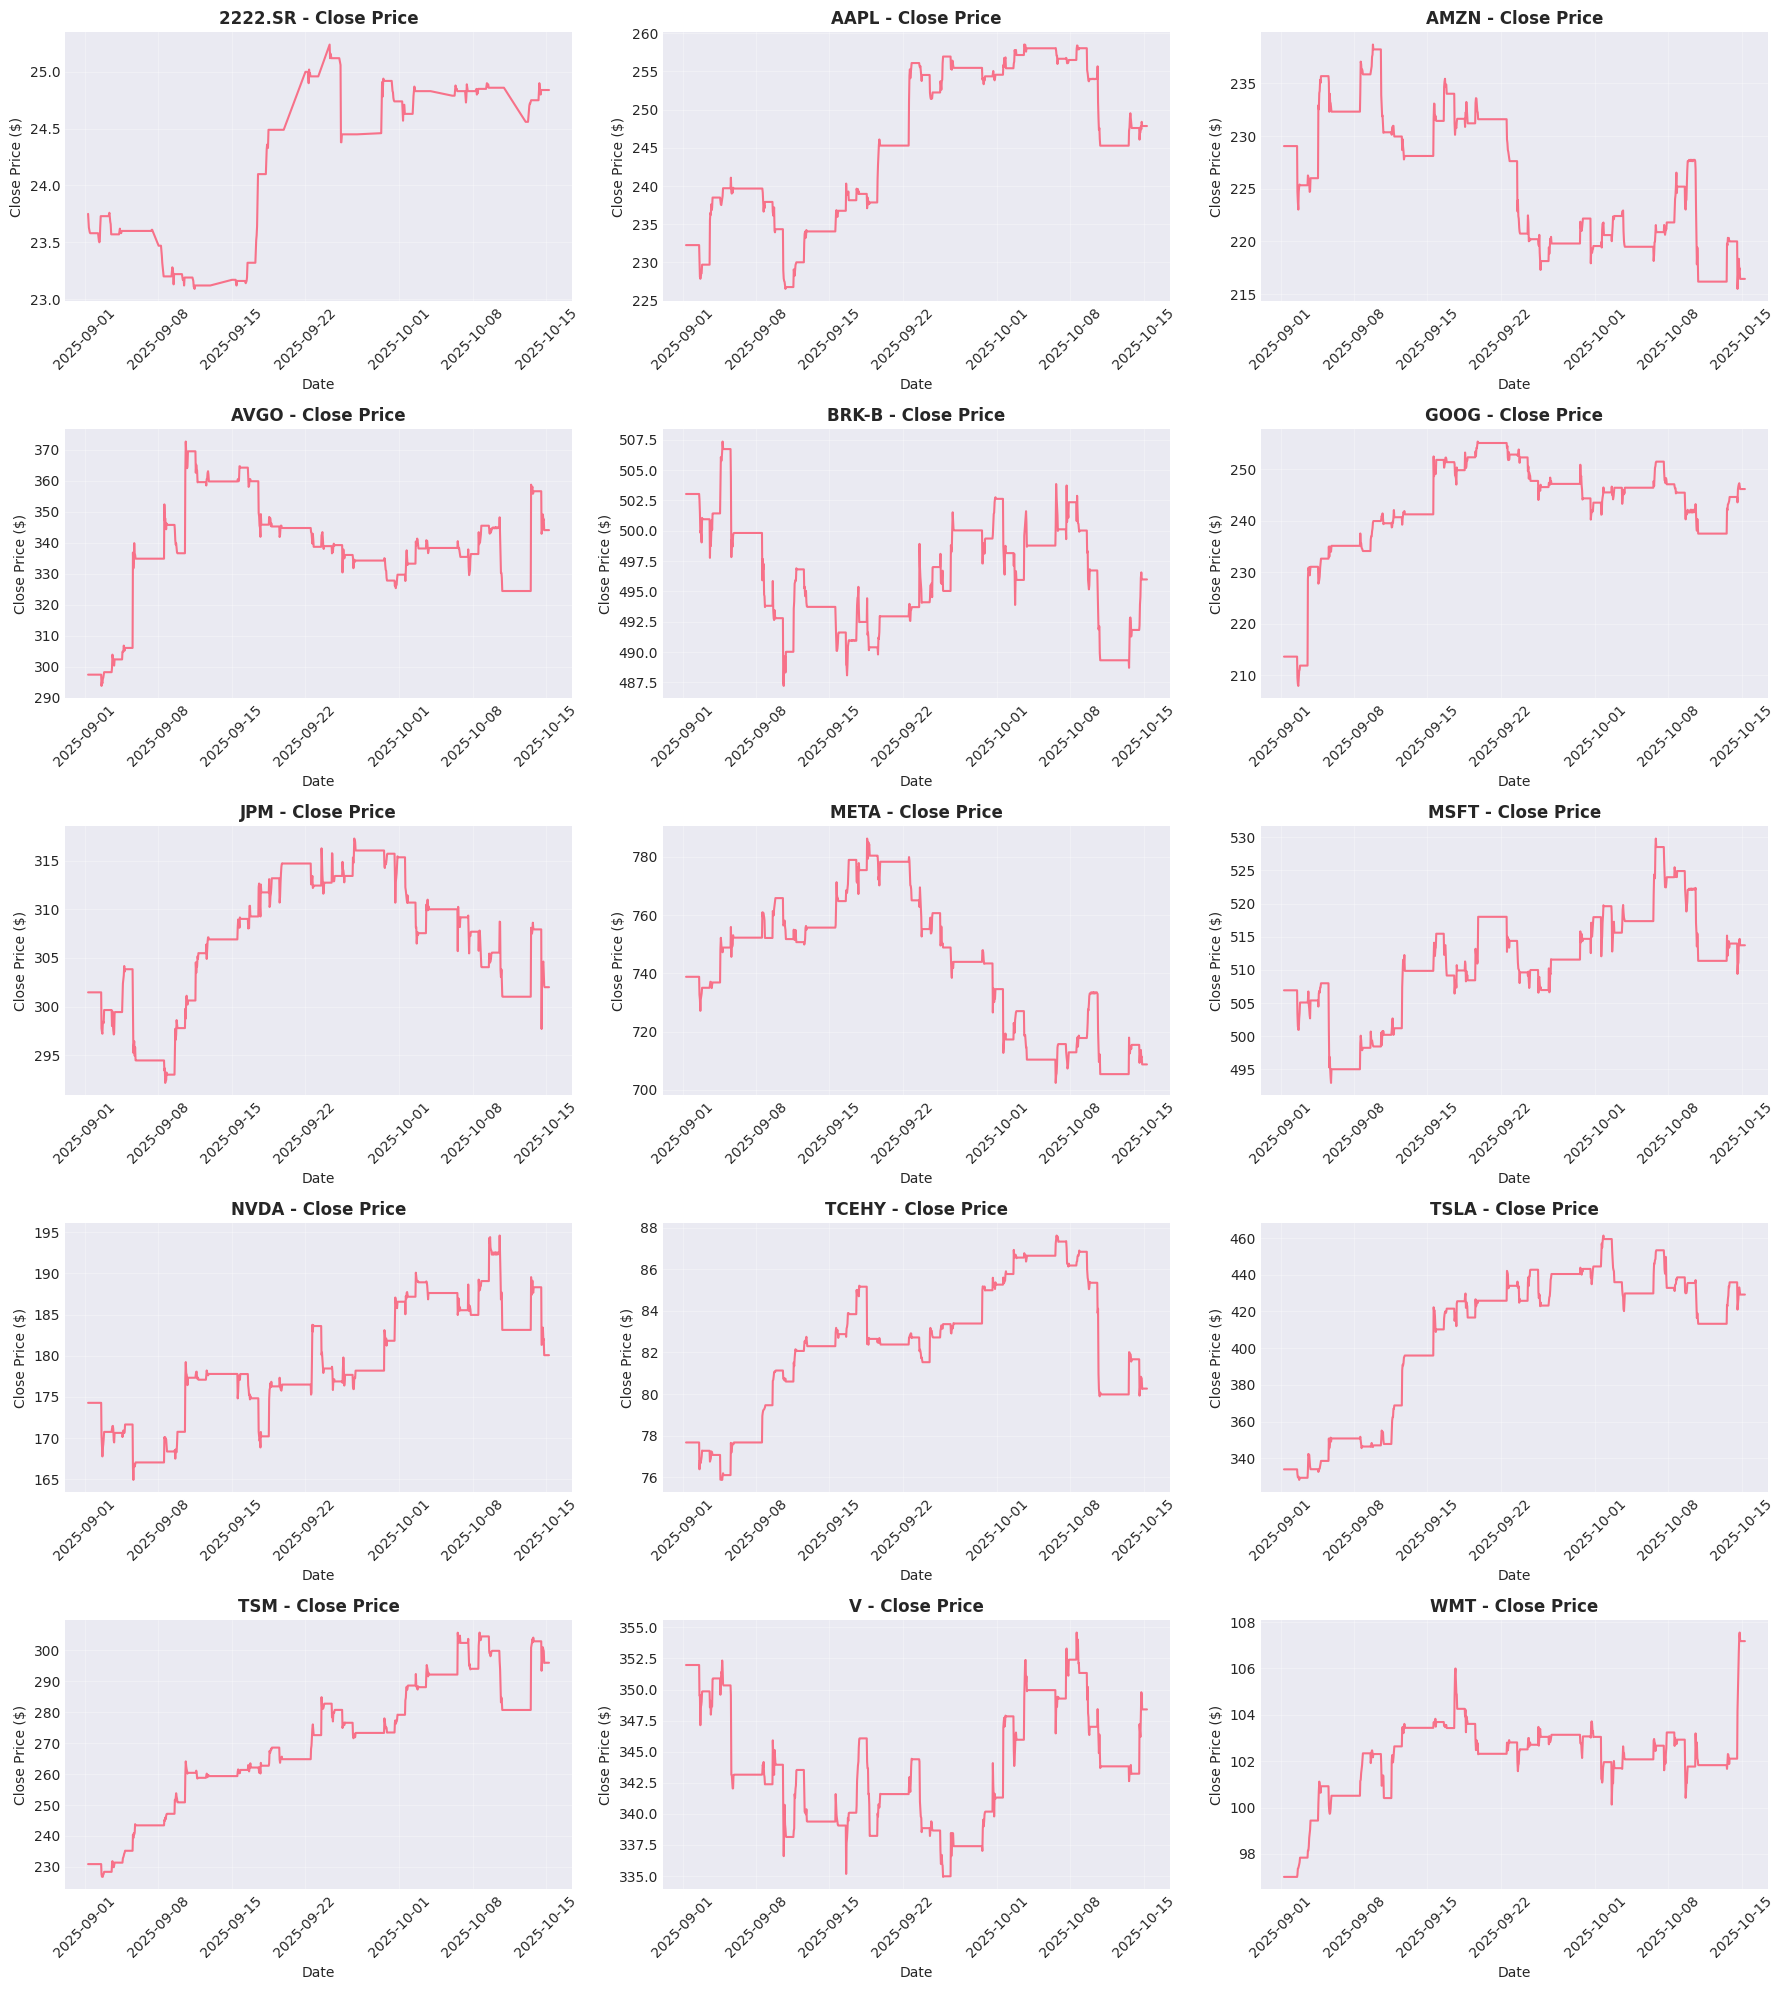

In [11]:
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")
    axes[i].plot(symbol_df["timestamp"], symbol_df["close_price"], linewidth=1.5)
    axes[i].set_title(f"{symbol} - Close Price", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Close Price ($)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Moving Averages

In [12]:
def add_moving_averages(df):
    """
    Add moving averages to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.

    Returns:
    pd.DataFrame: DataFrame with moving averages added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of moving averages
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol

        # Simple Moving Averages
        df.loc[mask, "sma_5"] = df.loc[mask, "close_price"].rolling(window=5).mean()
        df.loc[mask, "sma_10"] = df.loc[mask, "close_price"].rolling(window=10).mean()
        df.loc[mask, "sma_20"] = df.loc[mask, "close_price"].rolling(window=20).mean()
        df.loc[mask, "sma_50"] = df.loc[mask, "close_price"].rolling(window=50).mean()

        # Exponential Moving Averages
        df.loc[mask, "ema_5"] = (
            df.loc[mask, "close_price"].ewm(span=5, adjust=False).mean()
        )
        df.loc[mask, "ema_10"] = (
            df.loc[mask, "close_price"].ewm(span=10, adjust=False).mean()
        )
        df.loc[mask, "ema_20"] = (
            df.loc[mask, "close_price"].ewm(span=20, adjust=False).mean()
        )
        df.loc[mask, "ema_50"] = (
            df.loc[mask, "close_price"].ewm(span=50, adjust=False).mean()
        )

    return df


df = add_moving_averages(df)
print("Moving averages added to DataFrame.")
df.head()

Moving averages added to DataFrame.


,symbol,open_price,high,low,close_price,volume,market_cap,timestamp,date_only,timestamp_et,hour,day_of_week,is_trading_hours,sma_5,sma_10,sma_20,sma_50,ema_5,ema_10,ema_20,ema_50
0,2222.SR,23.81,23.82,23.73,23.75,517621,5.744056e+12,2025-09-01 07:27:29.329835+00:00,2025-09-01,2025-09-01 03:27:29.329835-04:00,3,0,False,NaN,NaN,NaN,NaN,23.750000,23.750000,23.750000,23.750000
1,2222.SR,23.70,23.71,23.69,23.69,35782,5.729545e+12,2025-09-01 08:17:47.795969+00:00,2025-09-01,2025-09-01 04:17:47.795969-04:00,4,0,False,NaN,NaN,NaN,NaN,23.730000,23.739091,23.744286,23.747647
2,2222.SR,23.63,23.63,23.63,23.63,0,5.715033e+12,2025-09-01 09:15:07.264998+00:00,2025-09-01,2025-09-01 05:15:07.264998-04:00,5,0,False,NaN,NaN,NaN,NaN,23.696667,23.719256,23.733401,23.743033
3,2222.SR,23.63,23.64,23.60,23.61,2372396,5.710197e+12,2025-09-01 10:14:05.476706+00:00,2025-09-01,2025-09-01 06:14:05.476706-04:00,6,0,False,NaN,NaN,NaN,NaN,23.667778,23.699391,23.721649,23.737816
4,2222.SR,23.61,23.61,23.57,23.59,1521688,5.705360e+12,2025-09-01 11:10:40.868525+00:00,2025-09-01,2025-09-01 07:10:40.868525-04:00,7,0,False,23.654,NaN,NaN,NaN,23.641852,23.679502,23.709111,23.732020


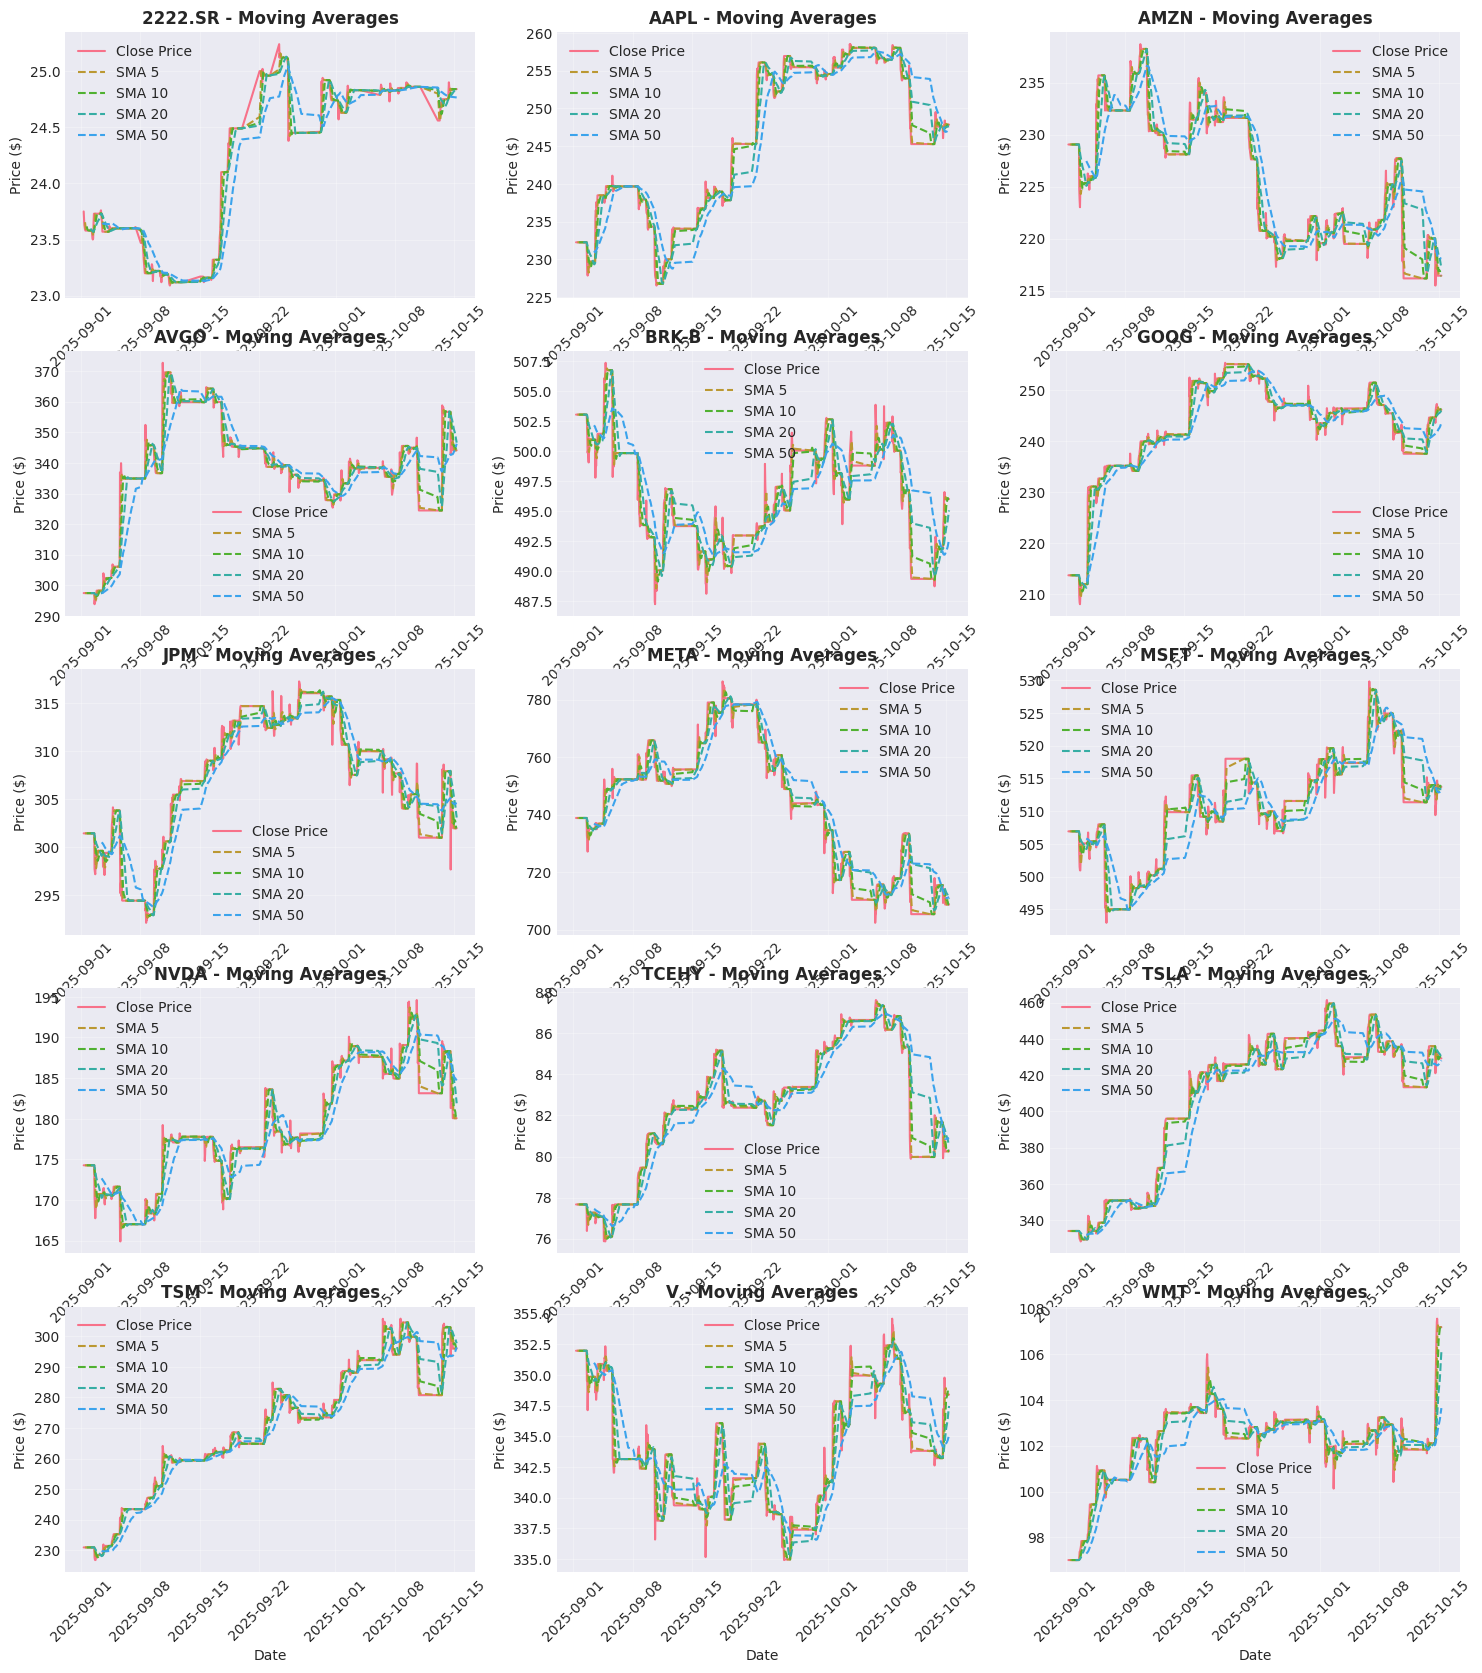

In [13]:
# Visualize moving averages

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")

    axes[i].plot(
        symbol_df["timestamp"],
        symbol_df["close_price"],
        label="Close Price",
        linewidth=1.5,
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["sma_5"], label="SMA 5", linestyle="--"
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["sma_10"], label="SMA 10", linestyle="--"
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["sma_20"], label="SMA 20", linestyle="--"
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["sma_50"], label="SMA 50", linestyle="--"
    )

    axes[i].set_title(f"{symbol} - Moving Averages", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Price ($)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

### Adding Relative Strength Index (RSI)

In [14]:
def add_rsi(df, period=14):
    """
    Add Relative Strength Index (RSI) to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.
    period (int): Period for RSI calculation.

    Returns:
    pd.DataFrame: DataFrame with RSI added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of RSI
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol
        close_prices = df.loc[mask, "close_price"]

        # Calculate price changes
        delta = close_prices.diff()

        # Separate gains and losses
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()

        # Calculate RS and RSI
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))

        df.loc[mask, "rsi"] = rsi

    return df


df = add_rsi(df)
print(f' RSI range: {df["rsi"].min()} to {df["rsi"].max()}')

 RSI range: 0.0 to 100.0


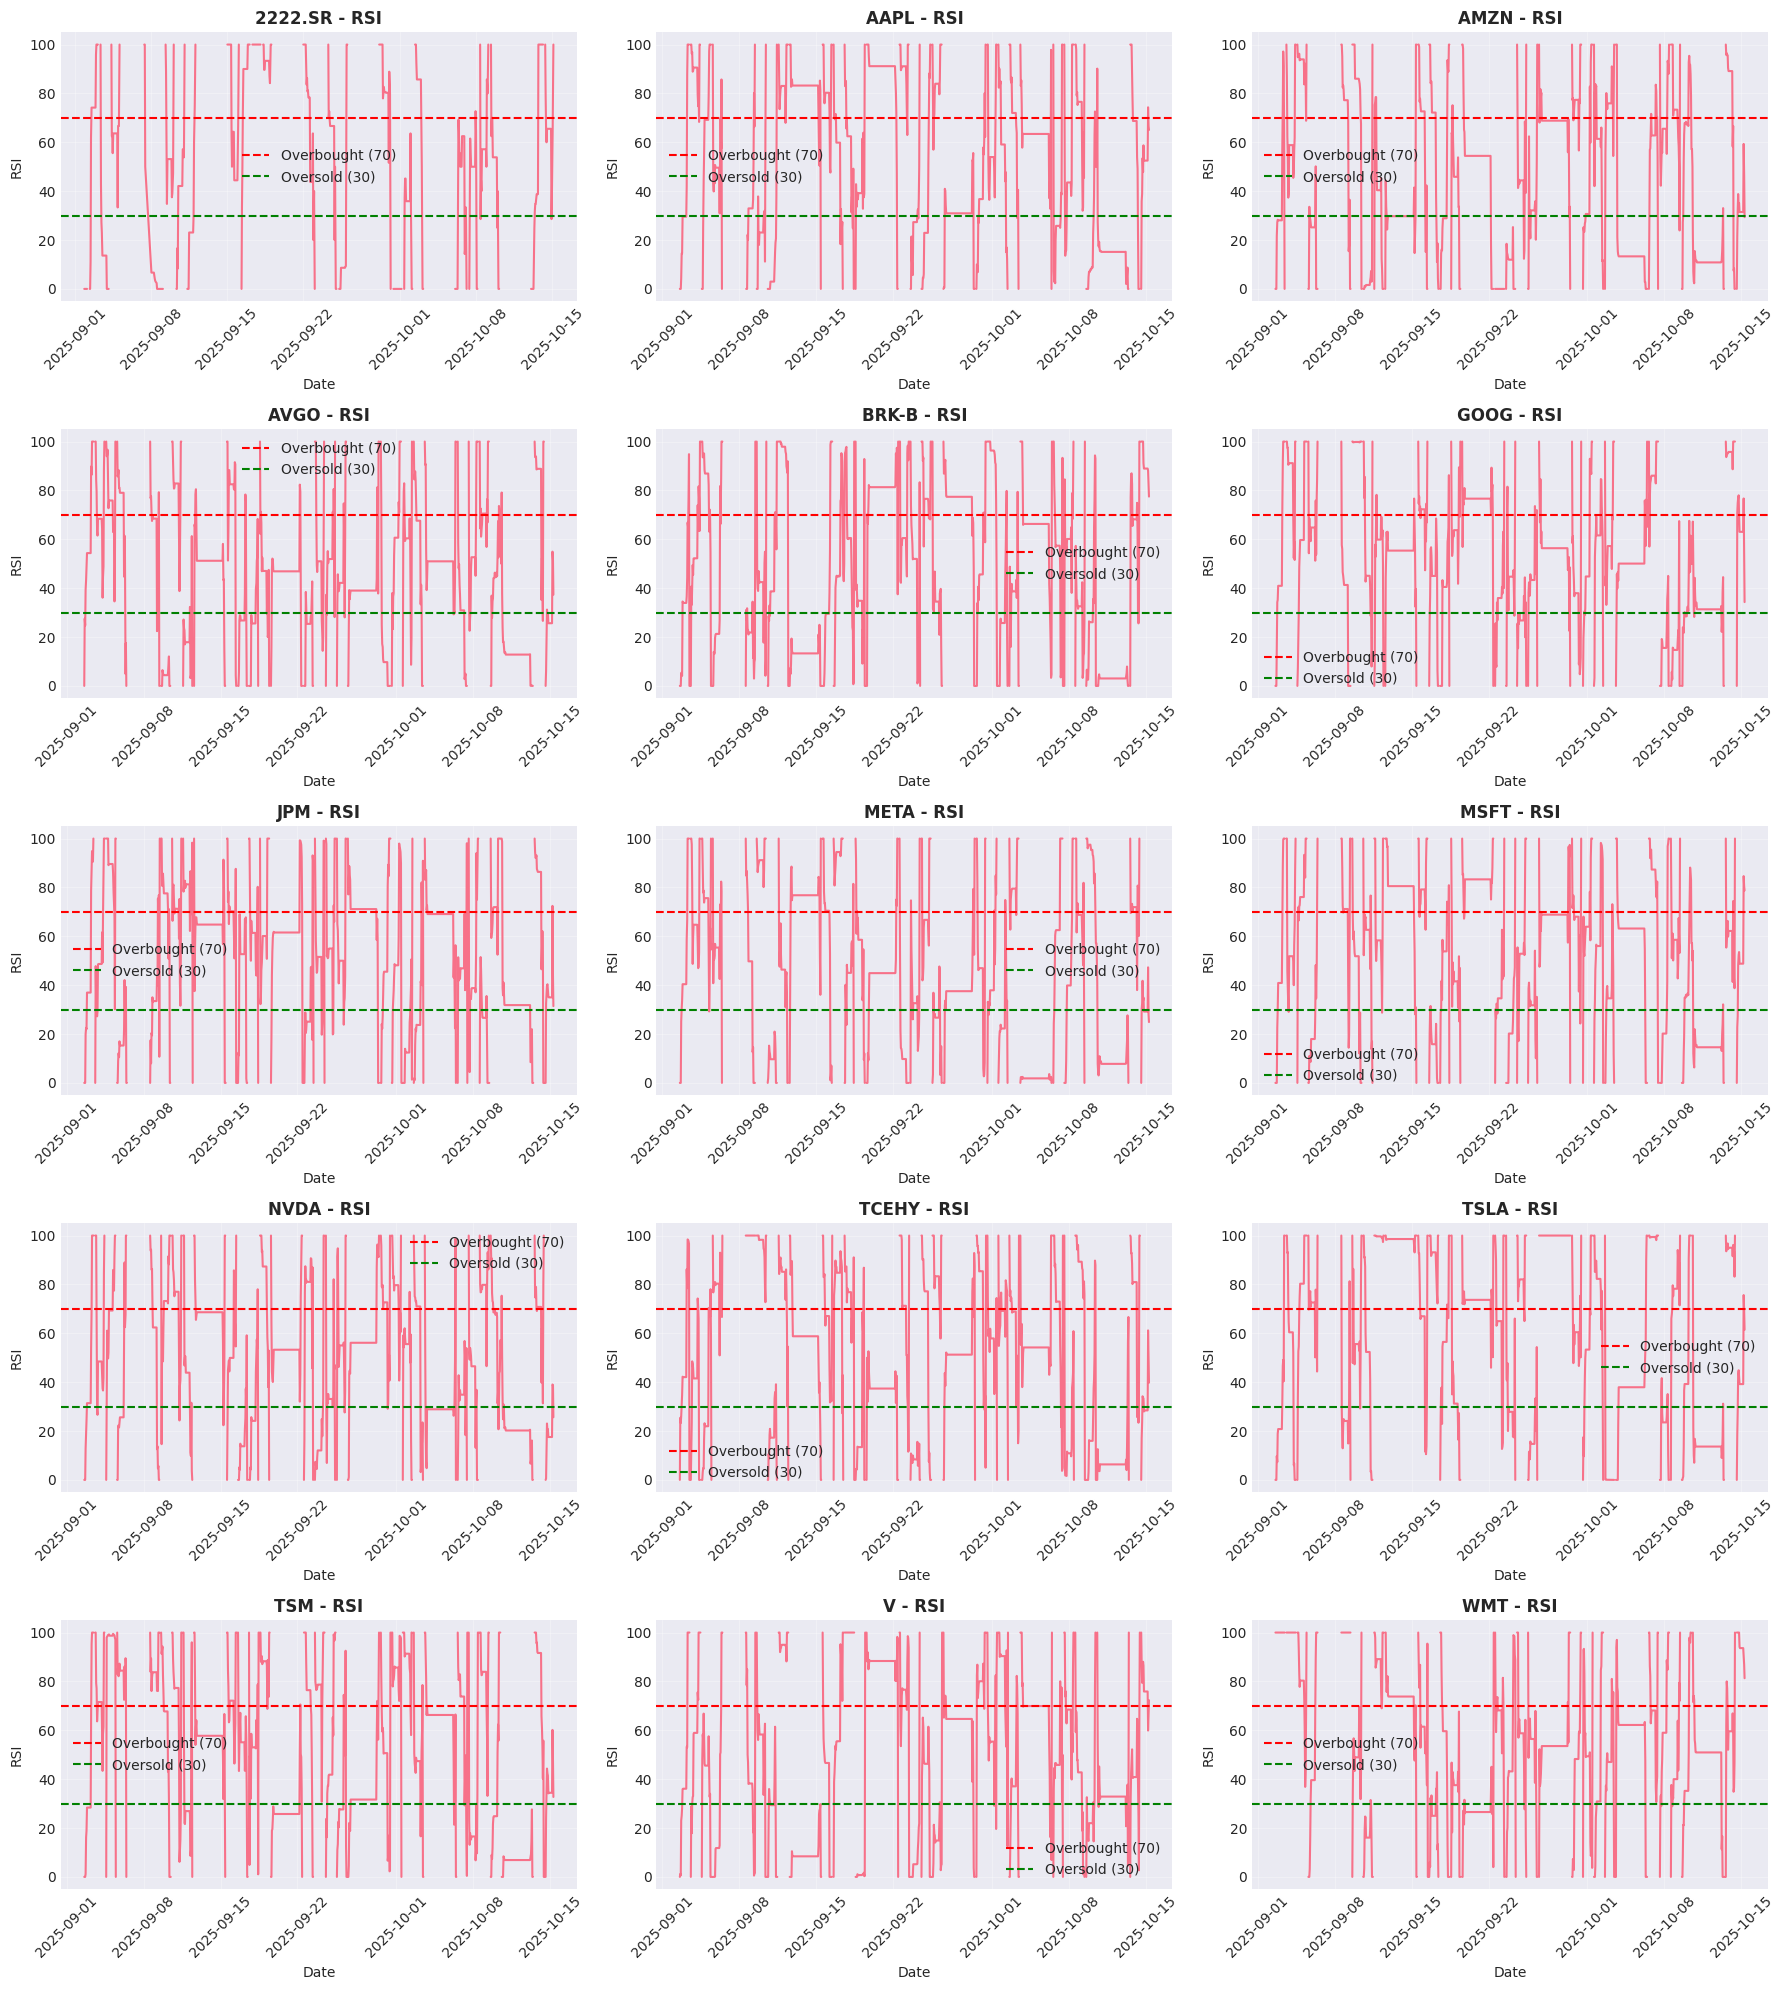

In [16]:
# Visualizing RSI

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")

    axes[i].plot(symbol_df["timestamp"], symbol_df["rsi"], linewidth=1.5)
    axes[i].axhline(70, color="red", linestyle="--", label="Overbought (70)")
    axes[i].axhline(30, color="green", linestyle="--", label="Oversold (30)")

    axes[i].set_title(f"{symbol} - RSI", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("RSI")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Adding MACD

In [18]:
def add_macd(df, fast=12, slow=26, signal=9):
    """
    Add MACD (Moving Average Convergence Divergence) to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.
    fast (int): Fast EMA period.
    slow (int): Slow EMA period.
    signal (int): Signal line period.

    Returns:
    pd.DataFrame: DataFrame with MACD and Signal Line added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of MACD
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol
        close_prices = df.loc[mask, "close_price"]

        # Calculate MACD
        exp1 = close_prices.ewm(span=fast, adjust=False).mean()
        exp2 = close_prices.ewm(span=slow, adjust=False).mean()

        macd = exp1 - exp2
        macd_signal = macd.ewm(span=signal, adjust=False).mean()
        macd_hist = macd - macd_signal

        df.loc[mask, "macd"] = macd
        df.loc[mask, "macd_signal"] = macd_signal
        df.loc[mask, "macd_hist"] = macd_hist

    return df


df = add_macd(df)
print(f' MACD columns: {[col for col in df.columns if "macd" in col]}')

 MACD columns: ['macd', 'macd_signal', 'macd_hist']


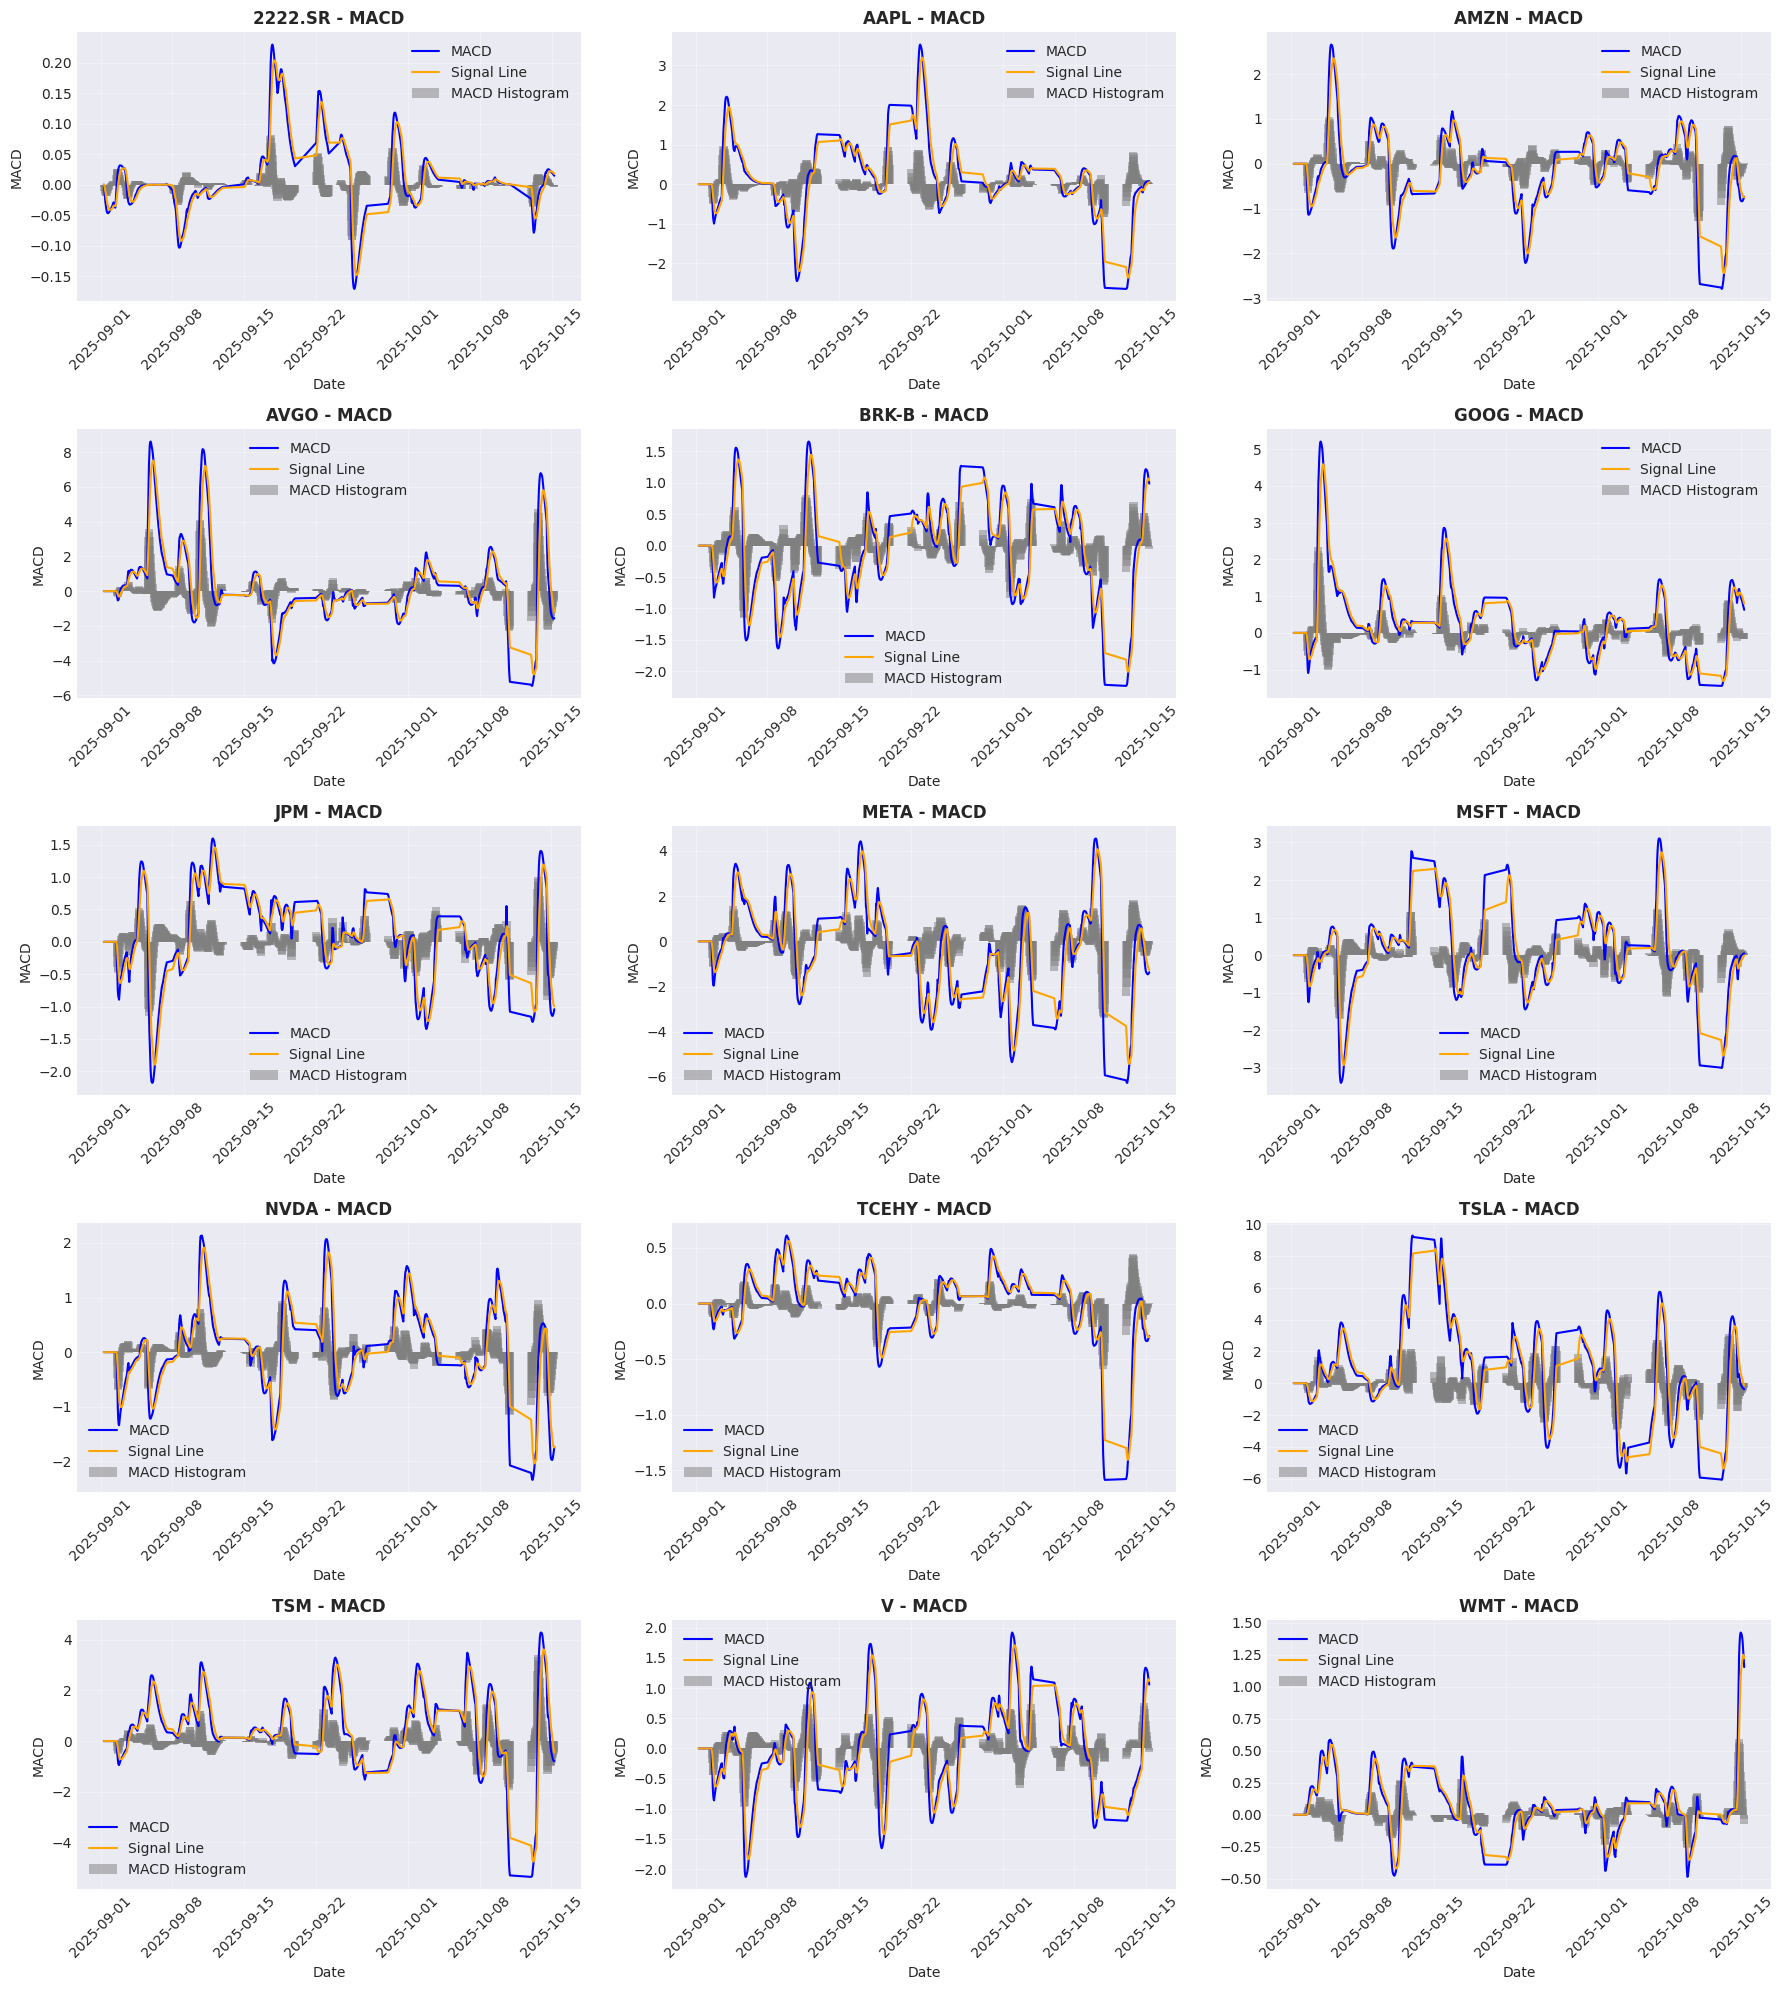

In [19]:
# Visualizing MACD

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")

    axes[i].plot(symbol_df["timestamp"], symbol_df["macd"], label="MACD", color="blue")
    axes[i].plot(
        symbol_df["timestamp"],
        symbol_df["macd_signal"],
        label="Signal Line",
        color="orange",
    )
    axes[i].bar(
        symbol_df["timestamp"],
        symbol_df["macd_hist"],
        label="MACD Histogram",
        color="gray",
        alpha=0.5,
    )

    axes[i].set_title(f"{symbol} - MACD", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("MACD")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()